# 一： 推理机制 (Inference)

**目标：** 从数学和直观的角度理解大语言模型（LLM）是如何工作的。我们将忽略底层的工程代码实现，重点关注数据如何在模型中流动，以及“文本”是如何转化为“矩阵运算”的。

**前置知识：** 线性代数。

In [13]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from model.model_minimind import MiniMindConfig
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import json
from trainer.trainer_utils import init_model

# 设置绘图风格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False

print("环境准备完毕！")


lm_config = MiniMindConfig(hidden_size=512, num_hidden_layers=8, use_moe=False)
model, tokenizer = init_model(lm_config, "pretrain", "./model", "./out")
model.eval()

环境准备完毕！
所加载Model可训练参数：25.830 百万


MiniMindForCausalLM(
  (model): MiniMindModel(
    (embed_tokens): Embedding(6400, 512)
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-7): 8 x MiniMindBlock(
        (self_attn): Attention(
          (q_proj): Linear(in_features=512, out_features=512, bias=False)
          (k_proj): Linear(in_features=512, out_features=128, bias=False)
          (v_proj): Linear(in_features=512, out_features=128, bias=False)
          (o_proj): Linear(in_features=512, out_features=512, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
        (mlp): FeedForward(
          (gate_proj): Linear(in_features=512, out_features=1408, bias=False)
          (down_proj): Linear(in_features=1408, out_features=512, bias=False)
          (up_proj): Linear(in_features=512, out_features=1408, bias=False)
          (drop

## 从文本到数字：Tokenization (分词)

计算机无法直接理解“苹果”或“Apple”这样的字符，它只能处理数字。第一步是将人类语言离散化。

### 什么是 Token？
Token 是模型处理的最小单位，它可以是一个词语，也可以是单字。

In [2]:
# 输入一个句子
text = "国科大学生好幸福！"
# 分词过程
ids = tokenizer.encode(text)
print(f"原始文本: {text}")
print(f"分词结果")
for i in ids:
    print(f"  '{tokenizer.decode([i])}' -> {i}")
print(f"数字索引 (ids):   {ids}")

原始文本: 国科大学生好幸福！
分词结果
  '国' -> 1317
  '科' -> 1493
  '大' -> 611
  '学生' -> 3061
  '好' -> 587
  '幸福' -> 4302
  '！' -> 2207
数字索引 (ids):   [1317, 1493, 611, 3061, 587, 4302, 2207]


## 语义空间：Embedding (词向量)

整数 ID (如 `50256`) 只是一个索引，没有任何语义信息（比如 ID 100 和 ID 101 在语义上不一定相似）。我们需要将每个 Token 映射到一个**高维向量空间**。

### Embedding 矩阵
假设词表大小为 $V$ (例如 50,000)，我们设定一个向量维度 $d$ (例如 512)。
我们将每个 Token $s_i$ 映射为一个向量 $\mathbf{x}_i \in \mathbb{R}^d$。

### 词向量的几何性质 (线性关系)
训练好的词向量具有神奇的几何性质：**语义相似的词在空间中距离更近，且具有方向性的语义关系。**

最著名的例子是：$\vec{King} - \vec{Man} + \vec{Woman} \approx \vec{Queen}$


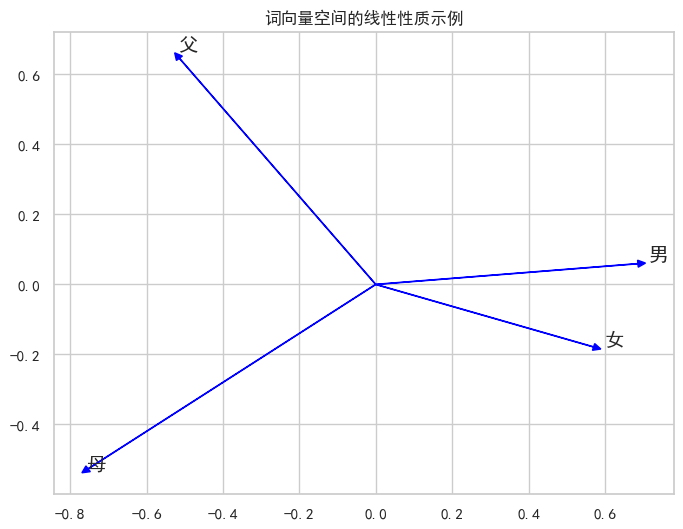

In [8]:
def plot_word_vectors(words:list[str]):
    # 模拟训练好的高维向量在2D平面的投影
    vectors = []
    for w in words:
        id = tokenizer.encode(w)[0]
        with torch.no_grad():
            vec = model.model.embed_tokens.weight[id].cpu().numpy()
        vectors.append(vec)
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)
    plt.figure(figsize=(8, 6))
    # 绘制向量点
    for i, word in enumerate(words):
        x, y = reduced_vectors[i]
        plt.arrow(0, 0, x, y, head_width=0.02, head_length=0.02, fc='blue', ec='blue', length_includes_head=True)
        plt.text(x + 0.01, y + 0.01, word, fontsize=14)
    plt.title("词向量空间的线性性质示例")
    plt.grid(True)
    plt.show()

plot_word_vectors(["男", "女", "父", "母"])

## 模型核心：Transformer (矩阵变换机器)

大语言模型（如 GPT）本质上就是一个巨大的函数 $f$。
它吞入一个矩阵 $\mathbf{X}$，处理其中的每个向量，吐出一个相同大小的矩阵 $\mathbf{H}$。

$$ \mathbf{H} = f_{\theta}(\mathbf{X}) $$

其中 $f_{\theta}$ 由数百亿个参数组成，主要是多层 Transformer Block 堆叠而成。

In [3]:
text = tokenizer.bos_token + "国科大学生好幸"
print("输入句子：", text)
ids = tokenizer.encode(text)
input_mat = model.model.embed_tokens.weight[ids]
print(f"输入句子的ids: {ids}") 
print(f"输入句子的词向量矩阵: {input_mat.shape}") 
torch.set_printoptions(precision=2, sci_mode=False, edgeitems=5, threshold=10, linewidth=150)
print(input_mat.detach())
output = model(torch.tensor([ids], dtype=torch.long, device=model.device))
output_mat = output['hidden_states'][0]
print(f"输出的词向量矩阵: {output_mat.shape}") 
print(output_mat.detach())

输入句子： <|im_start|>国科大学生好幸
输入句子的ids: [1, 1317, 1493, 611, 3061, 587, 3729]
输入句子的词向量矩阵: torch.Size([7, 512])
tensor([[ 0.00, -0.01, -0.03,  0.01, -0.00,  ...,  0.04, -0.05, -0.04, -0.04, -0.03],
        [ 0.05,  0.01,  0.01, -0.09,  0.01,  ..., -0.06, -0.07, -0.05,  0.07, -0.01],
        [-0.06, -0.06, -0.01, -0.05,  0.03,  ...,  0.05,  0.05, -0.10,  0.00, -0.11],
        [ 0.01,  0.06,  0.00, -0.09, -0.07,  ..., -0.12, -0.04, -0.06,  0.02, -0.02],
        [-0.09, -0.03, -0.01,  0.13,  0.08,  ...,  0.00, -0.05,  0.10,  0.06,  0.03],
        [ 0.08, -0.13, -0.08, -0.09, -0.08,  ...,  0.02, -0.07,  0.06,  0.08, -0.06],
        [ 0.04, -0.03, -0.01, -0.03, -0.04,  ..., -0.05,  0.17,  0.05,  0.07,  0.01]], device='cuda:0')
输出的词向量矩阵: torch.Size([7, 512])
tensor([[    -0.65,     -0.29,     -0.86,     -0.62,      0.11,  ...,     -0.61,      0.00,      0.34,     -1.28,      4.78],
        [    -0.88,      1.24,      0.72,      1.31,      0.36,  ...,      0.51,      0.98,     -0.44,      0.01,   

## 预测下一个 Token：概率分布

经过多层 Transformer 处理后，我们得到了输出矩阵 $\mathbf{H} \in \mathbb{R}^{L \times d}$。
我们只关心最后一个位置的向量 $\mathbf{h}_{last}$，因为它包含了整个句子的语义信息，用来预测下一个词。

### 投影与 Softmax
这里执行与Tokenize相反的操作：从词向量中解读出其对应的文字

我们收将 $\mathbf{h}_{last}$ 投影回词表大小 $V$：
$$ \mathbf{z} = \mathbf{h}_{last} \mathbf{W}_{unemb} $$
其中 $\mathbf{z} \in \mathbb{R}^V$ 是 logits（未归一化的分数）。

然后使用 **Softmax** 函数将其转换为概率分布：
$$ P(w_i) = \frac{e^{z_i}}{\sum_{j=1}^{V} e^{z_j}} $$

h_last (torch.Size([512])): tensor([ 1.1553e+00, -3.1857e-01, -3.5766e-01, -8.6411e-01,  1.6965e-01,
         7.0876e-02, -1.7511e+00,  3.3658e-01,  2.9087e-01, -1.2851e-01,
        -2.6263e+00, -1.0311e+00,  1.8031e+00, -7.1114e-01,  7.5037e-01,
        -2.0139e+00, -9.2144e-01, -1.2800e+00,  1.1739e+00,  1.6856e-01,
        -9.6968e-01,  7.9911e-01, -1.1415e+00,  2.7706e+00,  5.8248e-01,
        -9.8676e-02,  2.5836e+00, -1.7866e+00, -1.5506e-01, -3.8702e-01,
         3.7240e-01, -2.5436e+00, -5.2395e-02,  9.5167e-01, -2.2400e+00,
        -6.2530e-01,  1.5960e+00,  1.2232e+00,  8.6293e-02,  7.7892e-01,
         1.3829e+00, -2.9372e+00,  1.3971e+00,  1.0866e+00, -9.0417e-01,
        -5.7667e-02, -1.5115e+00,  1.6001e+00, -2.0594e-01,  2.1326e+00,
         1.2563e+00, -1.0822e+00,  2.4180e+00,  2.1696e+00, -1.3297e+00,
        -2.3398e+00,  5.9942e-01, -1.8621e+00, -1.5592e-01, -1.5344e+00,
        -3.4927e+00,  9.1239e-01, -5.8375e-01,  8.0528e-01,  1.0507e+00,
         3.7446e-01, -5

/tmp/ipykernel_4378/2032868322.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words, y=probabilities, palette="viridis")
/home/rickt/.conda/envs/minimind/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


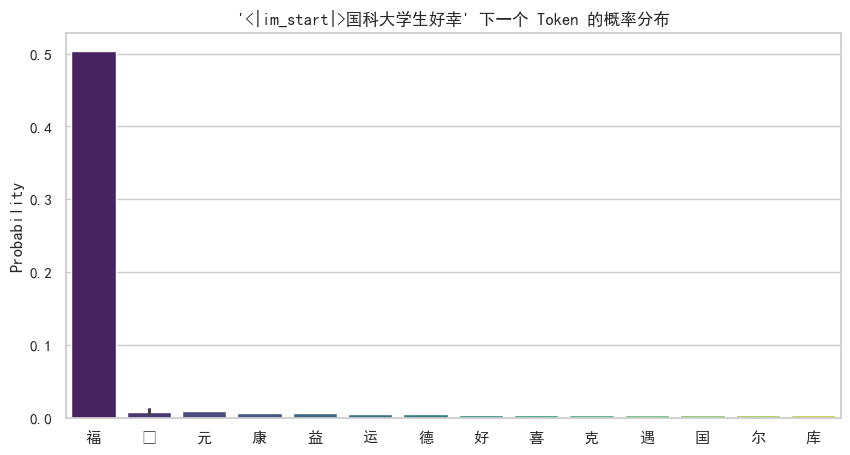

In [89]:
h_last = output['hidden_states'][-1][-1]
print(f"h_last ({h_last.shape}): {h_last}\n")
z = model.lm_head(h_last)
print(f"z = h_last x lm_head ({z.shape}): {z}\n")
probs = torch.softmax(output['logits'][0, -1, :], dim=-1).detach().cpu()
print(f"probs = softmax(z) ({probs.shape}): {probs}\n\n")
top_k = 20
top_probs, top_indices = torch.topk(probs, top_k)
# 可视化概率分布
plt.figure(figsize=(10, 5))
words = [tokenizer.decode([idx]) for idx in top_indices]
probabilities = top_probs.numpy()
sns.barplot(x=words, y=probabilities, palette="viridis")
plt.title(f"'{text}' 下一个 Token 的概率分布")
plt.ylabel("Probability")
plt.show()

## 自回归生成 (Autoregressive Generation)

ChatGPT 等模型是如何生成长文本的？
答案是：**像接龙一样，一个词一个词地生成。**

过程如下：
1.  输入 $X$。
2.  模型预测下一个词 $y$。
3.  将 $y$ 拼接到 $X$ 后面，形成新的输入 $[X, y]$。
4.  重复步骤 1。

In [49]:
print("输入的文本：\n", text)
generate_ids = model.generate(torch.tensor([ids], dtype=torch.long, device=model.device), max_length=100, do_sample=True, top_k=10, temperature=0.8)
generated_text = tokenizer.decode(generate_ids[0].tolist())
print("生成的文本：\n", generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


输入的文本：
 <|im_start|>国科大学生好幸
生成的文本：
 <|im_start|>国科大学生好幸运

根据上文，进行歌词续写：
天下人间
我听见我听到的心
你说我有多美好
你是我最美好的明天
我听见我听到的心
你说我有多美好
你是我最美好
你是我最美好
你是我最美好
你是我最美好
你是我


# 二：训练机制 (Training)

如果说推理是模型在“考试”，那么训练就是模型在“上课”。
大语言模型的训练通常分为两个核心阶段：
1.  **预训练 (Pre-training)**：学习语言的规律，获得通识知识（从文盲变成博学家，但不懂人类指令）。
2.  **后训练 (Post-training)**：学习对话的模式，对齐人类意图（学会如何做一个有用的助手）。

## 预训练：预测下一个词

预训练的目标非常单纯：**给定一段文本，预测下一个字是什么。**

模型通过阅读海量的互联网文本（Wiki、书籍、代码），试图最小化预测错误的概率。

In [100]:
with open('dataset/pretrain_hq.jsonl', 'r') as f:
    for i in range(2000):
        line = f.readline()
data = json.loads(line)
print("数据集样例：")
print(data['text'])

数据集样例：
<|im_start|>纠正语法错误。 
我没写好这个句子，你能纠正其中的语法错误吗？ 可以，请问是哪个句子存在语法错误呢？<|im_end|> <|im_start|>将以下句子中的动词改写成同义词。
她的脸颊变红了，当她听到那个笑话时。
她听到那个笑话时脸颊泛红了。<|im_end|> <|im_start|>为一篇长文本生成一个标题。
一篇说明健康饮食的长文本。标题：保持健康的饮食选择：探索适合你的饮食习惯<|im_end|> <|im_start|>给定一个句子，要求助手在语境中添加合适的形容词。
小狗在花园里玩。小小的狗在美丽的花园里欢乐地玩耍。<|im_end|> <|im_start|>给定一个句子，将其转换为另一种时态（过去、现在或将来时）。
明天我会见到朋友。
今天我将要见到朋友。<|im_end|> <|im_start|>将下面的文本中的语法错误修正。
"当我在超市，我看到了一只大象。"
当我在超市时，我看到了一只大象。<|im_end|> <|im_start|>对输入的句子进行配对操作，找到其中的同义词。
她很漂亮，具有吸引力。
她很漂亮和具有吸引力是同义词。<|im_end|> <|im_start|>提供一幅画作的描述，为其添加一个标题。
这幅画展现了一只猫，四周有几只鸟围绕着它飞。
标题： 猫与鸟<|im_end|>



### 训练数据的构造（错位预测）

假设我们要训练模型学习一句话：“**国科大学生好幸福**”。

这是一个监督学习（Supervised Learning）问题。

*   **Input (输入)**: 喂给模型的当前上文。
*   **Target (目标)**: 模型应该预测出的下一个字（作为标准答案）。

这在实现上非常高效：我们将句子复制一份，向左移动一格，就得到了目标序列。

| 时间步 ($t$) | 输入 ($x_t$) | 模型推断 | 目标|
| :--- | :---: | :---: | :---: | 
| 1 | `[BOS]` | $\to$ | **国** | 
| 2 | **国** | $\to$ | **科** | 
| 3 | **科** | $\to$ | **大** | 
| 4 | **大** | $\to$ | **学** | 
| 5 | **学** | $\to$ | **生** | 
| 6 | **生** | $\to$ | **好** | 
| 7 | **好** | $\to$ | **幸** | 
| 8 | **幸** | $\to$ | **福** | 
| 9 | **福** | $\to$ | `[EOS]` | 

我们的目标是最大化模型输出目标的概率（还记得模型的输出其实是个概率分布吗？）


### 模型是如何“进化”的：损失函数与梯度下降

现在我们看看如何更新模型的参数，将模型的输出与目标输出靠近

#### 损失函数：衡量模型输出与目标输出之间的距离

对于大语言模型，我们通常使用**交叉熵损失**。
假设对于输入“国科大学生好幸”，下一个词的真实标签是“福”（ID 为 $y$）。
模型输出的概率分布为 $\hat{y}$（经过 Softmax 后的概率向量）。

对于真实目标词 $y$ 的预测概率为 $P(y)$，损失函数定义为：
$$ L = - \log(P(y)) $$

- 如果模型预测“福”的概率是 0.9 (很有信心)，$L = -\log(0.9)$ (损失很小)。
- 如果模型预测“福”的概率是 0.01 (完全猜错)，$L = -\log(0.01)$ (损失很大，惩罚严重)。

把所有位置上的损失相加，得到总损失

**我们的目标：找到一组参数 $\theta$，使得总损失 $\mathcal{L}$ 最小。**

In [95]:
text = tokenizer.bos_token + "国科大学生好幸"
print("输入句子：", text)
Y = "福"
print("目标下一个词：", Y)
ids = tokenizer.encode(text)
target_id = tokenizer.encode(Y)[0]
input_ids = torch.tensor([ids], dtype=torch.long, device=model.device)
target_ids = torch.tensor([target_id], dtype=torch.long, device=model.device)
opti = torch.optim.AdamW(model.parameters(), lr=1e-6)
model.train()
output = model(input_ids)
logits = output['logits']
last_logits = logits[0, -1, :]
probs = torch.softmax(last_logits, dim=-1)
target_prob = probs[target_id]
print(f"目标词 '{Y}' 的预测概率: {target_prob.item():.6f}")
loss = -torch.log(target_prob + 1e-10)
print(f"目标词 '{Y}' 的损失: {loss.item():.6f}")
print(f"待更新参数数量：{sum(p.numel() for p in model.parameters() if p.requires_grad)}")

输入句子： <|im_start|>国科大学生好幸
目标下一个词： 福
目标词 '福' 的预测概率: 0.725025
目标词 '福' 的损失: 0.321549
待更新参数数量：25829888



#### 梯度下降：指导更新参数

可以将总损失 $\mathcal{L}$ 想象成连绵起伏的山脉，我们的模型现在站在山上的某一点（当前的参数状态）。
为了让损失最小，我们需要“下山”。

*   **梯度 ($\nabla \mathcal{L}$)**：指出了当前位置最陡峭的**上山**方向。
*   **更新策略**：我们可以沿着梯度的**反方向**走一步。

参数更新公式：
$$ \theta_{new} = \theta_{old} - \alpha \cdot \nabla \mathcal{L}(\theta_{old}) $$
其中 $\alpha$ 是**学习率 (Learning Rate)**，决定了我们步子迈多大。

这一过程就是**反向梯度传播**

In [94]:
print(f"目标词 '{Y}' 的预测概率: {target_prob.item():.6f}")
print(f"目标词 '{Y}' 的损失: {loss.item():.6f}")
print("反向传播开始...")
opti.zero_grad()
loss.backward()
opti.step()
output = model(input_ids)
logits = output['logits']
last_logits = logits[0, -1, :]
probs = torch.softmax(last_logits, dim=-1)
target_prob = probs[target_id]
loss = -torch.log(target_prob + 1e-10)
print(f"目标词 '{Y}' 的预测概率: {target_prob.item():.6f}")
print(f"目标词 '{Y}' 的损失: {loss.item():.6f}")

目标词 '福' 的预测概率: 0.676655
目标词 '福' 的损失: 0.390594
反向传播开始...
目标词 '福' 的预测概率: 0.725025
目标词 '福' 的损失: 0.321549


In [90]:
training_evolution_data = json.load(open('results_pretrain.json', 'r', encoding='utf-8'))
steps = range(1000, 44001, 1000)

def show_training_process(prompt, step):
    # 获取对应步数的输出
    # 这里的 step 映射到最近的模拟节点
    closest_step = min(steps, key=lambda x:abs(x-step))
    
    output = training_evolution_data[prompt][str(closest_step)]
    
    print("-" * 40)
    print(f"模型输出:\n{output}")
    print("-" * 40)

# 创建控件
prompt_dropdown = widgets.Dropdown(
    options=list(training_evolution_data.keys()),
    description='输入提示词:',
    style={'description_width': 'initial'}
)

step_slider = widgets.SelectionSlider(
    options=steps,
    value=1000,
    description='训练步数:',
    continuous_update=False
)

# 绑定交互
interactive_plot = widgets.interactive(show_training_process, prompt=prompt_dropdown, step=step_slider)
display(interactive_plot)

interactive(children=(Dropdown(description='输入提示词:', options=('你有什么特长？', '为什么天空是蓝色的', '请用Python写一个计算斐波那契数列的函数'…

## 2. 后训练：当一名合格的助手

经过预训练的模型（Base Model）虽然博学，但它不好用。
为什么？因为它的训练目标是“接龙”，而不是“助手”。

仅预训练：
```python
👶: 解释什么是机器学习
🤖️: ，并提供一个例子。
机器学习是一种人工智能技术，它使用计算机算法来分析数据，从数据中自动学习和改进，从而使计算机能够自主地学习和改进。

一个例子是自然语言处理，例如智能客服和自动翻译。它使用计算机算法和机器学习算法来自动处理和理解文本和语法规则，从而实现自然语言的自动化处理和理解。
```

后训练后
```python
👶: 解释什么是机器学习
🤖️: 机器学习是人工智能的一个分支，它利用计算机算法对数据进行分析和学习，以便能够自动化地学习和改进。机器学习是让计算机通过数据和算法自我学习，从而实现自主学习的能力，以便在未来做出更明智的决策。

机器学习是一种通过数据训练算法和模型，使计算机系统能够从经验中学习，以做出更好的决策。机器学习可以分为监督学习、无监督学习和强化学习三种类型，前者通过学习数据中的模式和规律来完成任务，而后者则通过学习数据中的模式和规律来完成任务。

...
```



### 改变数据的格式

SFT 阶段并没有改变“预测下一个词”的本质，但是**改变了数据的格式与风格**。我们将数据组织成“对话”的形式，教模型学会区分“用户”和“助手”。

**SFT 数据样例：**

In [99]:
with open('dataset/sft_mini_512.jsonl', 'r') as f:
    for i in range(500):
        line = f.readline()
data = json.loads(line)
print("数据集样例：")
for t in data['conversations']:
    print(t)
    
print("\n应用模版后，模型的实际训练输入：")
templates = {"conversation": data['conversations'], "tokenize": False, "add_generation_prompt": False}
inputs = tokenizer.apply_chat_template(**templates)
print(inputs)

数据集样例：
{'role': 'user', 'content': '你好，我最近遇到了一些难题，想请你帮忙解答。'}
{'role': 'assistant', 'content': '你好！当然可以，我很乐意帮助你。请告诉我你遇到了什么难题，我们一起看看怎么解决。'}

应用模版后，模型的实际训练输入：
<|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
你好，我最近遇到了一些难题，想请你帮忙解答。<|im_end|>
<|im_start|>assistant
你好！当然可以，我很乐意帮助你。请告诉我你遇到了什么难题，我们一起看看怎么解决。<|im_end|>



In [42]:
training_evolution_data = json.load(open('results_fullsft.json', 'r', encoding='utf-8'))
steps = range(1000, 150001, 1000)

def show_training_process(prompt, step):
    # 获取对应步数的输出
    # 这里的 step 映射到最近的模拟节点
    closest_step = min(steps, key=lambda x:abs(x-step))
    
    output = training_evolution_data[prompt][str(closest_step)]
    
    print("-" * 40)
    print(f"模型输出:\n{output}")
    print("-" * 40)

# 创建控件
prompt_dropdown = widgets.Dropdown(
    options=list(training_evolution_data.keys()),
    description='输入提示词:',
    style={'description_width': 'initial'}
)

step_slider = widgets.SelectionSlider(
    options=steps,
    value=1000,
    description='训练步数:',
    continuous_update=False
)

# 绑定交互
interactive_plot = widgets.interactive(show_training_process, prompt=prompt_dropdown, step=step_slider)
display(interactive_plot)

interactive(children=(Dropdown(description='输入提示词:', options=('你有什么特长？', '为什么天空是蓝色的', '请用Python写一个计算斐波那契数列的函数'…